<a href="https://colab.research.google.com/github/TubaSatoglu/pp_collision1-Pythia8313/blob/main/Monte_Carlo_CalibrationParameter_Calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Reference:**
EURAMET cg-17, Version 3.0, March 2017
"Guidelines on the Calibration of Electromechanical Manometers"
European Association of National Metrology Institutes (EURAMET)

In [7]:
pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 3.9 MB/s eta 0:00:00


## **Hysteresis Calculation (N=1000)**

This code calculates hysteresis directly from the provided Excel file (manometre_kalibrasyonu.xlsx) using the given resolution value (= 0.01).
The calculation follows the equations described in EURAMET No.17, page 24, where hysteresis is evaluated based on the difference between increasing and decreasing pressure readings.

Since performing the hysteresis calculation using the obtained datasets can be quite complex, we developed a dedicated code tailored to the given data structure.
However, this implementation can certainly be further improved and generalized for broader use in different calibration formats.

In [4]:
"""
Hysteresis Monte Carlo from Calibration Excel
---------------------------------------------

This script computes the hysteresis of a pressure gauge directly from a calibration
Excel workbook (`manometre_kalibrasyonu.xlsx`). It reads both reference and test
instrument readings from fixed cell locations, performs Monte Carlo simulations
to model the influence of resolution, and exports the hysteresis results.

Why fixed Excel cell addresses?
-------------------------------
Hysteresis in manometer calibration is a complex process involving paired
measurements (increasing and decreasing pressure) and zero-reference corrections.
Because the data layout in the calibration worksheet mirrors the laboratory
measurement procedure, reading values directly from their cell positions
ensures that the code reproduces the real calibration logic faithfully.

Layout (default):
-----------------
- Rows: 7–17 correspond to setpoints (0–1000 bar)
- References:  C–H  →  Ref1_(+), Ref2_(-), …, Ref6_(-)
- Test (DUT):  I–N  →  M1_(+), M2_(-), …, M6_(-)
- Resolution:  D23  →  instrument resolution value

Algorithm overview:
-------------------
1. Load reference and test data from Excel.
2. Build (-, 0, +) variants for each test reading using ±resolution.
3. For each setpoint:
   - At 0 bar: compute hysteresis using three reference–test pairs and average them.
   - For non-zero points: randomly sample from (-, 0, +) variants and compute
     hysteresis relative to reference readings.
4. Repeat for N_iter Monte Carlo iterations.
5. Output mean, std, min, max hysteresis values per setpoint into an Excel file.

Usage:
------
    python hysteresis_mc.py

Output:
-------
    hysteresis1000_final.xlsx
"""

import pandas as pd
import numpy as np
import random
import openpyxl
from openpyxl.utils import column_index_from_string

file_name = "manometre_kalibrasyonu.xlsx"
output_file = "hysteresis1000_final.xlsx"

row_min, row_max = 7, 17
cols_test = {
    "M1_(+)": "I",
    "M2_(-)": "J",
    "M3_(+)": "K",
    "M4_(-)": "L",
    "M5_(+)": "M",
    "M6_(-)": "N"
}
cols_ref = {
    "Ref1_(+)": "C",
    "Ref2_(-)": "D",
    "Ref3_(+)": "E",
    "Ref4_(-)": "F",
    "Ref5_(+)": "G",
    "Ref6_(-)": "H"
}
resolution_cell = "D23"
N_iter = 1000   # Number of Monte Carlo iterations

wb = openpyxl.load_workbook(file_name, data_only=True)
ws = wb.active
resolution = ws[resolution_cell].value

def get_column_values(ws, col_letter, rmin, rmax):
    """Extract numeric values from a specific Excel column between two row indices."""
    col_idx = column_index_from_string(col_letter)
    values = []
    for r in range(rmin, rmax + 1):
        v = ws.cell(row=r, column=col_idx).value
        values.append(float(v) if isinstance(v, (int, float)) else None)
    return values

# Hysteresis calculation functions
def calc_hysteresis_general(m1_vals, m2_vals, ref1, ref2, zero_ref, zero_test):
    """
    Calculate hysteresis for non-zero points by randomizing test values.
    Selects random (−, 0, +) variants for each iteration.
    """
    m1 = random.choice(m1_vals)
    m2 = random.choice(m2_vals)
    d_m1 = m1 - zero_test
    d_m2 = m2 - zero_test
    d_ref1 = ref1 - zero_ref
    d_ref2 = ref2 - zero_ref
    return abs((d_m2 - d_m1) - (d_ref1 - d_ref2))

def calc_hysteresis_zero(m1_vals, m2_vals, m3_vals, m4_vals, m5_vals, m6_vals,
                         ref1, ref2, ref3, ref4, ref5, ref6):
    """
    Special hysteresis calculation at 0 bar using all three test/reference pairs.
    """
    term1 = abs((m2_vals - m1_vals) - (ref2 - ref1))
    term2 = abs((m4_vals - m3_vals) - (ref4 - ref3))
    term3 = abs((m6_vals - m5_vals) - (ref6 - ref5))
    return np.mean([term1, term2, term3])

# Generate test variants (–, 0, +)
data_test = {}
for name, col in cols_test.items():
    values = get_column_values(ws, col, row_min, row_max)
    data_test[f"-{name}"] = [v - resolution if r > row_min else v
                             for r, v in zip(range(row_min, row_max + 1), values)]
    data_test[f"0{name}"] = values
    data_test[f"+{name}"] = [v + resolution if r > row_min else v
                             for r, v in zip(range(row_min, row_max + 1), values)]

df_test = pd.DataFrame(data_test)

# Reference data (unchanged)
data_ref = {}
for name, col in cols_ref.items():
    data_ref[name] = get_column_values(ws, col, row_min, row_max)
df_ref = pd.DataFrame(data_ref)

# Monte Carlo hysteresis calculation
results = []
for i in range(len(df_test)):   # For each setpoint (0–1000 bar)
    row = {}
    setpoint = df_test.loc[i, "0M1_(+)"]
    hyst_values = []

    for _ in range(N_iter):
        if i == 0:  # 0 bar → use special formula
            hyst = calc_hysteresis_zero(
                df_test.loc[i, "0M1_(+)"], df_test.loc[i, "0M2_(-)"],
                df_test.loc[i, "0M3_(+)"], df_test.loc[i, "0M4_(-)"],
                df_test.loc[i, "0M5_(+)"], df_test.loc[i, "0M6_(-)"],
                df_ref.loc[i, "Ref1_(+)"], df_ref.loc[i, "Ref2_(-)"],
                df_ref.loc[i, "Ref3_(+)"], df_ref.loc[i, "Ref4_(-)"],
                df_ref.loc[i, "Ref5_(+)"], df_ref.loc[i, "Ref6_(-)"]
            )
        else:
            m1_vals = [df_test.loc[i, "-M1_(+)"], df_test.loc[i, "0M1_(+)"], df_test.loc[i, "+M1_(+)"]]
            m2_vals = [df_test.loc[i, "-M2_(-)"], df_test.loc[i, "0M2_(-)"], df_test.loc[i, "+M2_(-)"]]
            ref1 = df_ref.loc[i, "Ref1_(+)"]
            ref2 = df_ref.loc[i, "Ref2_(-)"]
            zero_test = df_test.loc[0, "0M1_(+)"]
            zero_ref = df_ref.loc[0, "Ref1_(+)"]
            hyst = calc_hysteresis_general(m1_vals, m2_vals, ref1, ref2, zero_ref, zero_test)

        hyst_values.append(hyst)

    row["setpoint"] = setpoint
    row["hysteresis_mean"] = np.mean(hyst_values)
    row["hysteresis_std"] = np.std(hyst_values)
    row["hysteresis_min"] = np.min(hyst_values)
    row["hysteresis_max"] = np.max(hyst_values)
    results.append(row)

df_hyst = pd.DataFrame(results)
df_gap1 = pd.DataFrame({"": [None] * len(df_test)})
df_gap2 = pd.DataFrame({" ": [None] * len(df_test)})
df_all = pd.concat([df_test, df_gap1, df_ref, df_gap2, df_hyst], axis=1)

df_all.to_excel(output_file, index=False)

print(f"Completed → {output_file}")
print(f"Hysteresis calculation finished successfully with N = {N_iter} iterations.")

Completed → hysteresis1000_final.xlsx
Hysteresis calculation finished successfully with N = 1000 iterations.


## **Calculation of Averages:**
The datasets expanded using the resolution values were combined through Monte Carlo iterations, and the average values of these combinations were computed.

In [3]:
import numpy as np
import pandas as pd
from openpyxl import load_workbook
from openpyxl.utils import column_index_from_string

input_xlsx = "manometre_kalibrasyonu.xlsx"
output_xlsx = "ortalamalar_excel.xlsx"

row_min, row_max = 7, 17            # data rows
increasing_cols = ["I", "K", "M"]   # increasing pressure columns (M1, M3, M5)
decreasing_cols = ["J", "L", "N"]   # decreasing pressure columns (M2, M4, M6)
resolution_cell = "D23"             # resolution cell
override_resolution = None          # e.g., 0.01 -> skip reading from D23
n_simulations = 1000                # number of Monte Carlo iterations


def read_numeric(ws, coord):
    """Read a numeric cell value safely."""
    v = ws[coord].value
    return float(v) if isinstance(v, (int, float)) else None

def get_column_values(ws, col_letter, rmin, rmax):
    """Extract values from a specific Excel column between two row indices."""
    col_idx = column_index_from_string(col_letter)
    values = []
    for r in range(rmin, rmax + 1):
        v = ws.cell(row=r, column=col_idx).value
        values.append(float(v) if isinstance(v, (int, float)) else np.nan)
    return np.array(values, dtype=float)

def random_choice_with_variants(value, res, n, rng):
    """
    For a single measurement value, randomly choose n samples from
    the set (value - res, value, value + res).
    """
    variants = np.array([value - res, value, value + res], dtype=float)
    idx = rng.integers(0, 3, size=n)
    return variants[idx]

def run_simulation(ws, cols, row_min, row_max, resolution, n_simulations, rng):
    """
    Perform Monte Carlo simulation on selected columns.
    For each measurement point, randomly pick ±resolution variants across
    all three columns and compute their mean for each iteration.
    """
    cols_data = [get_column_values(ws, c, row_min, row_max) for c in cols]

    row_numbers = np.arange(row_min, row_max + 1)
    setpoints = cols_data[0].copy()

    # Store simulated results
    results = np.zeros((row_max - row_min + 1, n_simulations))
    for i in range(len(row_numbers)):
        draws = [random_choice_with_variants(cols_data[j][i], resolution, n_simulations, rng)
                 for j in range(3)]
        results[i, :] = np.mean(draws, axis=0)

    col_names = [f"sim_{k+1}" for k in range(n_simulations)]
    df = pd.DataFrame(results, columns=col_names)
    df["mean_of_simulations"] = df[col_names].mean(axis=1)
    return df

wb = load_workbook(input_xlsx, data_only=True)
ws = wb.active

if override_resolution is not None:
    resolution = float(override_resolution)
else:
    resolution = read_numeric(ws, resolution_cell)
    if resolution is None:
        raise ValueError(f"Resolution value could not be read from cell {resolution_cell}!")

print(f"Resolution = {resolution}")

rng = np.random.default_rng(42)

# Run simulations for increasing & decreasing readings
df_increasing = run_simulation(ws, increasing_cols, row_min, row_max, resolution, n_simulations, rng)
df_decreasing = run_simulation(ws, decreasing_cols, row_min, row_max, resolution, n_simulations, rng)

with pd.ExcelWriter(output_xlsx) as writer:
    df_increasing.to_excel(writer, sheet_name="increasing", index=False)
    df_decreasing.to_excel(writer, sheet_name="decreasing", index=False)

print(f"Completed → {output_xlsx}")
print("Monte Carlo averaging finished successfully.")

Resolution = 0.01
Completed → ortalamalar_excel.xlsx
Monte Carlo averaging finished successfully.


## **f(0) zero error:**


The file **expanded_dataset.xlsx** contains datasets generated by adding and subtracting the resolution value to each measurement (including the zero-pressure point).
This dataset can be used when performing the **f₀ (zero offset)** calculation or other uncertainty analyses.

In [ ]:
# expanded_dataset.xlsx generation

import pandas as pd
import openpyxl
from openpyxl.utils import column_index_from_string

file_name = "manometre_kalibrasyonu.xlsx"
output_file = "expanded_dataset.xlsx"

row_min, row_max = 7, 17
cols = {
    "M1_increasing": "I",
    "M2_decreasing": "J",
    "M3_increasing": "K",
    "M4_decreasing": "L",
    "M5_increasing": "M",
    "M6_decreasing": "N"
}
resolution_cell = "D23"

wb = openpyxl.load_workbook(file_name, data_only=True)
ws = wb.active
resolution = ws[resolution_cell].value

def get_column_values(ws, col_letter, rmin, rmax):
    col_idx = column_index_from_string(col_letter)
    values = []
    for r in range(rmin, rmax + 1):
        v = ws.cell(row=r, column=col_idx).value
        values.append(float(v) if isinstance(v, (int, float)) else None)
    return values

# Generate (−, 0, +) variants for each column by adding and subtracting resolution
data = {}
for name, col in cols.items():
    values = get_column_values(ws, col, row_min, row_max)
    data[f"-{name}"] = [v - resolution for v in values]
    data[f"0{name}"] = [v for v in values]
    data[f"+{name}"] = [v + resolution for v in values]

df = pd.DataFrame(data)
df.to_excel(output_file, index=False)

print(f"Completed → {output_file}")
print("Resolution added and subtracted from the original dataset.")

## **f(0) zero error**
In this code, the data provided in the Excel file and the resolution value (= 0.01) are used directly to calculate the hysteresis according to the equations described in EURAMET No.17, page 23.

In [ ]:
"""
f(0) Zero Deviation Calculation
-------------------------------

This script calculates the f(0) zero offset (zero deviation) using the data
from the calibration Excel files. The calculation follows the equations
described in **EURAMET No.17, page 23**.

Data sources:
- `expanded_dataset.xlsx`: contains the test data expanded with ±resolution
  variations (−M1, 0M1, +M1, …, +M6)
- `manometre_kalibrasyonu.xlsx`: contains the reference readings (columns C–H)

For each measurement cycle (M1–M2, M3–M4, M5–M6), the code performs Monte Carlo
sampling (N = 1000 iterations) to evaluate the zero deviation between the
test instrument and the reference.

The maximum of the three cycle deviations is reported as the final zero deviation.

Usage:
    python f0_zero_deviation.py
"""

import pandas as pd
import numpy as np
import openpyxl
from openpyxl.utils import column_index_from_string

file_test = "expanded_dataset.xlsx"          # test dataset (−M1, 0M1, +M1, …, +M6)
file_ref  = "manometre_kalibrasyonu.xlsx"    # reference readings (columns C..H)
output    = "f0_summary_full.xlsx"

row_min, row_max = 7, 17
N = 1000
seed = 42
rng = np.random.default_rng(seed)

# Load test data (expanded dataset)
df_test = pd.read_excel(file_test)

# Reference data (C..H, rows 7..17)
wb = openpyxl.load_workbook(file_ref, data_only=True)
ws = wb.active

def get_column_values(ws, col_letter, rmin, rmax):
    """Read numeric values from a given Excel column."""
    col_idx = column_index_from_string(col_letter)
    vals = []
    for r in range(rmin, rmax + 1):
        v = ws.cell(row=r, column=col_idx).value
        vals.append(float(v) if isinstance(v, (int, float)) else None)
    return vals

cols_ref = {
    "Ref1_increasing": "C", "Ref2_decreasing": "D",
    "Ref3_increasing": "E", "Ref4_decreasing": "F",
    "Ref5_increasing": "G", "Ref6_decreasing": "H",
}

data_ref = {name: get_column_values(ws, col, row_min, row_max)
            for name, col in cols_ref.items()}

df_ref = pd.DataFrame(data_ref)

# Zero deviation calculation
row0_test = df_test.iloc[0]
row0_ref  = df_ref.iloc[0]

def mc_cycle(m_up_list, m_down_list, r_up, r_down, n, rng):
    """Monte Carlo cycle for zero deviation (f(0)) calculation."""
    vals = []
    for _ in range(n):
        m_down = rng.choice(m_down_list)
        m_up   = rng.choice(m_up_list)
        delta_test = m_down - m_up
        delta_ref  = r_down - r_up
        vals.append(abs(delta_test - delta_ref))
    return float(np.mean(vals))

# Perform MC for three cycles
cycle1 = mc_cycle(
    [row0_test["-M1_increasing"], row0_test["0M1_increasing"], row0_test["+M1_increasing"]],
    [row0_test["-M2_decreasing"], row0_test["0M2_decreasing"], row0_test["+M2_decreasing"]],
    row0_ref["Ref1_increasing"], row0_ref["Ref2_decreasing"], N, rng
)
cycle2 = mc_cycle(
    [row0_test["-M3_increasing"], row0_test["0M3_increasing"], row0_test["+M3_increasing"]],
    [row0_test["-M4_decreasing"], row0_test["0M4_decreasing"], row0_test["+M4_decreasing"]],
    row0_ref["Ref3_increasing"], row0_ref["Ref4_decreasing"], N, rng
)
cycle3 = mc_cycle(
    [row0_test["-M5_increasing"], row0_test["0M5_increasing"], row0_test["+M5_increasing"]],
    [row0_test["-M6_decreasing"], row0_test["0M6_decreasing"], row0_test["+M6_decreasing"]],
    row0_ref["Ref5_increasing"], row0_ref["Ref6_decreasing"], N, rng
)

max_dev = max(cycle1, cycle2, cycle3)

df_zero = pd.DataFrame({
    "Cycle": [
        "Cycle 1: M2 - M1",
        "Cycle 2: M4 - M3",
        "Cycle 3: M6 - M5",
        "Max Zero Deviation",
    ],
    "Zero Deviation": [cycle1, cycle2, cycle3, max_dev]
})

# Export to Excel
gap1 = pd.DataFrame({"": [None]*len(df_test)})   # gap between test and ref
gap2 = pd.DataFrame({" ": [None]*len(df_test)})  # gap between ref and cycle results

with pd.ExcelWriter(output, engine="openpyxl") as xw:
    wide = pd.concat([df_test, gap1, df_ref, gap2], axis=1)
    wide.to_excel(xw, sheet_name="data", index=False)
    startcol = wide.shape[1]
    df_zero.to_excel(xw, sheet_name="data", index=False, startcol=startcol)

print(f"Completed → {output}")
print("f(0) zero deviation calculation finished.")

## **Expanded Uncertainty Calculation (N=100...)**
*   The code can be re-run multiple times by changing the number of iterations.

*   In the table on page 24, when the uncertainty is calculated only for 100 bar, we get:
U = 2 × 0.0132 (where U = k × u₍c₎, with k = 2).
The square root of the total variance gives u₍c₎, the combined standard uncertainty (contribution uncertainty).

*   The resulting expanded uncertainty (for 100 bar) is approximately 0.026, but this value is not explicitly written in the table.
Instead, the note below the table states: “Expanded uncertainty is not smaller than 0.2% FS.” Since the pressure range in the table is from 0 to 250 bar,
0.2% of 250 bar = 0.50 bar, meaning the minimum reported uncertainty should be 0.50 bar.

*   In the code, I intentionally did not divide by √3, because doing so made the results constant—removing the random variability from the simulation.
*   The rectangular distribution is correctly implemented by the line:
samples = rng.uniform(-a, a, N) → so there is no issue.


**Analytical (formula-based) approach:** u = interval / (2.0 * sqrt(3.0))

**Monte Carlo (random sampling) approach:** u = samples.std(ddof=1)

In [5]:
import numpy as np
import pandas as pd
from math import sqrt

# NORMAL distribution: treated as ±2σ (so σ = interval / 4)
# RECTANGULAR distribution: treated as half-width 'a' (so u = a / sqrt(3))
params = [
    ("p_ref",    0.0164, "normal"),
    ("p_test",   0.0010, "rectangular"),
    ("p_zero",   0.0030, "rectangular"),
    ("p_repeat", 0.0280, "rectangular"),
    ("p_his",    0.0330, "rectangular"),
]

# Sensitivity coefficients for the measurement model
sensitivity = {
    "p_ref":   -1,
    "p_test":   1,
    "p_zero":   1,
    "p_repeat": 1,
    "p_his":    1,
}

iterations = 10000           # CAN BE CHANGED
per_param_samples = 100      # samples drawn per parameter per iteration
all_results = []
U_values = []                # store U for each iteration (U = k * u_c)

for iteration in range(iterations):
    results = []
    variance_sum = 0.0

    for name, interval, dist in params:
        if dist == "normal":
            # Interpret 'interval' as ±2σ  ->  σ = interval / 4
            sigma = interval / 4.0
            samples = np.random.normal(0.0, sigma, per_param_samples)
        else:
            # Rectangular: half-width a = interval/2 if 'interval' is full width,
            # but here we keep your original approach:
            # u = interval / (2*sqrt(3))  =>  a = u * sqrt(3)
            u = interval / (2.0 * sqrt(3.0))
            a = u * sqrt(3.0)
            samples = np.random.uniform(-a, a, per_param_samples)

        mean_val = samples.mean()
        u_std = samples.std(ddof=1)
        contrib = sensitivity[name] * u_std
        var = contrib ** 2
        variance_sum += var

        results.append((name, mean_val, u_std, contrib, var))

    variance_sum = round(variance_sum, 6)
    u_c = sqrt(variance_sum)
    k = 2
    U = k * u_c
    U_values.append(U)

    results.append(('Σ variance', None, None, None, f"{variance_sum} bar^2"))
    results.append(('u_c (combined)', None, None, None, f"{u_c} bar"))
    results.append(('U (k=2)', None, None, None, f"{U} bar"))

    all_results.extend(results)
    all_results.append((None, None, None, None, None))  # blank row

U_mean = np.mean(U_values)
all_results.append(("Average U (k=2)", None, None, None, f"{U_mean} bar"))

df = pd.DataFrame(all_results, columns=[
    "Parameter",
    "Mean from MC (bar)",
    "Standard Uncertainty from MC (bar)",
    "Contribution to Uncertainty (bar)",
    "Variance (bar^2)",
])

output_file = "Expanded_Uncertainty10k.xlsx"
with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
    df.to_excel(writer, index=False, sheet_name="Results")

print(f"Results successfully saved to '{output_file}'.")
print(f"Average U (k=2): {U_mean:.6f} bar")

Results successfully saved to 'Expanded_Uncertainty10k.xlsx'.
Average U (k=2): 0.026352 bar


### Since a large amount of data would be generated, Excel export was not performed for 50k iterations and above — only the first three results were printed in the output (no Excel files created for N more than 50k cases).

In [ ]:
# N = 500k
import numpy as np
from math import sqrt

params = [
    ("p_ref",    0.0164, "normal"),
    ("p_test",   0.0010, "rectangular"),
    ("p_zero",   0.0030, "rectangular"),
    ("p_repeat", 0.0280, "rectangular"),
    ("p_his",    0.0330, "rectangular"),
]

# Sensitivity coefficients
sensitivity = {
    "p_ref": -1,
    "p_test": 1,
    "p_zero": 1,
    "p_repeat": 1,
    "p_his": 1,
}

iterations = 500_000   # CAN BE CHANGED
U_values = []
preview_results = []

# Monte Carlo
for iteration in range(iterations):
    variance_sum = 0

    for name, interval, dist in params:
        if dist == "normal":
            sigma = interval / 4.0
            samples = np.random.normal(0, sigma, 100)
        else:
            u = interval / (2.0 * sqrt(3))
            a = u * sqrt(3)
            samples = np.random.uniform(-a, a, 100)

        u = samples.std(ddof=1)
        contrib = sensitivity[name] * u
        var = contrib ** 2
        variance_sum += var

    variance_sum = round(variance_sum, 6)
    u_c = sqrt(variance_sum)
    k = 2
    U = k * u_c
    U_values.append(U)

    if iteration < 3:
        preview_results.append({
            "iteration": iteration + 1,
            "Σ variance": variance_sum,
            "u_c": u_c,
            "U (k=2)": U
        })

U_mean = np.mean(U_values)

print("Results for the first 3 iterations:")
for res in preview_results:
    print(f"Iter {res['iteration']}: Σ variance = {res['Σ variance']} | "
          f"u_c = {res['u_c']:.6f} | U(k=2) = {res['U (k=2)']:.6f}")

print(f"\nTotal number of iterations: {iterations}")
print(f"Average U (k=2): {U_mean:.6f} bar")

In [ ]:
# N = 1 million
import numpy as np
import pandas as pd
from math import sqrt

params = [
    ("p_ref",    0.0164, "normal"),
    ("p_test",   0.0010, "rectangular"),
    ("p_zero",   0.0030, "rectangular"),
    ("p_repeat", 0.0280, "rectangular"),
    ("p_his",    0.0330, "rectangular"),
]

# Sensitivity coefficients
sensitivity = {
    "p_ref": -1,
    "p_test": 1,
    "p_zero": 1,
    "p_repeat": 1,
    "p_his": 1,
}

iterations = 1_000_000
all_results = []
U_values = []

# Monte Carlo
for iteration in range(iterations):
    results = []
    variance_sum = 0.0

    for name, interval, dist in params:
        if dist == "normal":
            sigma = interval / 4.0
            samples = np.random.normal(0, sigma, 100)
        else:
            u = interval / (2.0 * sqrt(3))
            a = u * sqrt(3)
            samples = np.random.uniform(-a, a, 100)

        mean_val = samples.mean()
        u_std = samples.std(ddof=1)
        contrib = sensitivity[name] * u_std
        var = contrib ** 2
        variance_sum += var

        results.append((name, mean_val, u_std, contrib, var))

    variance_sum = round(variance_sum, 6)
    u_c = sqrt(variance_sum)

    k = 2
    U = k * u_c
    U_values.append(U)

    results.append(('Σ variance', None, None, None, f"{variance_sum} bar^2"))
    results.append(('u_c (combined)', None, None, None, f"{u_c} bar"))
    results.append(('U (k=2)', None, None, None, f"{U} bar"))

    all_results.extend(results)
    all_results.append((None, None, None, None, None))  # blank line

U_mean = np.mean(U_values)
all_results.append(("Average U (k=2)", None, None, None, f"{U_mean} bar"))

df = pd.DataFrame(all_results, columns=[
    "Parameter",
    "Mean from MC (bar)",
    "Standard Uncertainty from MC (bar)",
    "Contribution to Uncertainty (bar)",
    "Variance (bar^2)",
])

output_file = "Expanded_Uncertainty1M.xlsx"
with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
    df.to_excel(writer, index=False, sheet_name="Results")

print(f"Results successfully saved to '{output_file}'.")
print(f"Average U (k=2): {U_mean:.6f} bar")

## **Graph(s) Obtained Using Data from Different Iteration Runs**

#### **You may change the y-axis data in the plots; no significant differences will be observed.**

In this code, although the values obtained from different iterations (U_values) were manually entered, in our other scripts the plotting process was performed automatically by the code.

**It was observed that the graph converges to approximately ≈0.02635!**

*   Based on the hysteresis interval given in EURAMET No.17 Table E1a.3 (= 0.0330 bar), random data were generated for different iteration counts, and the resulting values were plotted.

*   For a fixed hysteresis interval, the standard uncertainty remains constant, and as the number of iterations increases, the results converge toward the standard deviation value specified for hysteresis in EURAMET No.17 Table E1a.3.

[EURAMET] Theoretical standard uncertainty = 0.00952628 bar
[EURAMET] Theoretical variance = 9.07500000e-05 bar^2

      N  Setpoint (bar)  MC mean (bar)  Standard Uncertainty (MC) (bar)  Variance (MC) (bar^2)  Abs error uncertainty (bar)
    100           100.0   5.858657e-04                         0.009949               0.000099                 4.224897e-04
    500           100.0  -3.657103e-05                         0.009657               0.000093                 1.308753e-04
   1000           100.0   2.111309e-04                         0.009416               0.000089                 1.107108e-04
  10000           100.0  -4.269358e-05                         0.009567               0.000092                 4.063228e-05
  50000           100.0   1.811838e-05                         0.009530               0.000091                 4.147611e-06
 100000           100.0  -7.352128e-05                         0.009512               0.000090                 1.384673e-05
 200000          

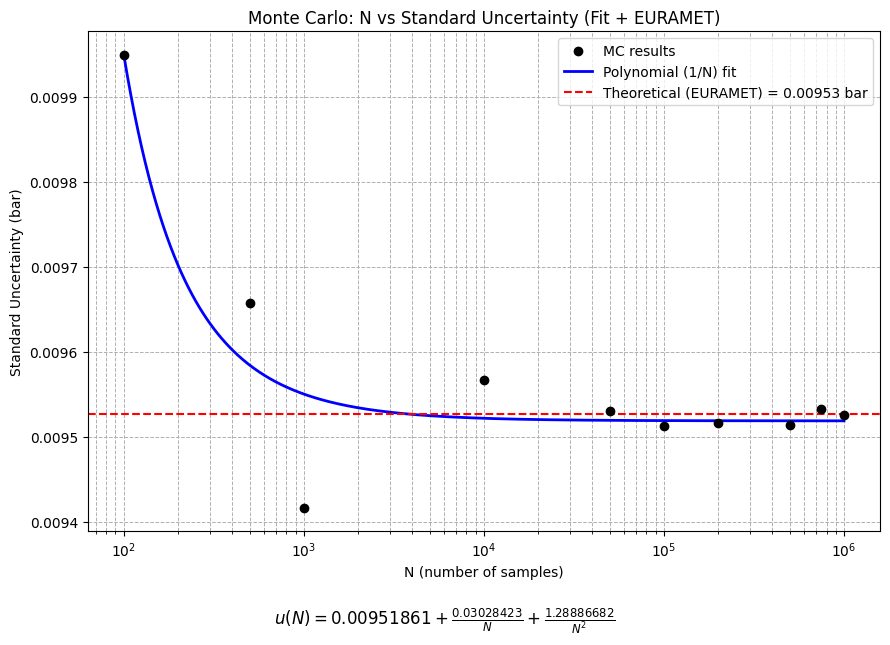

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

setpoint = 100.0    # nominal pressure (bar)
h = 0.0330          # hysteresis interval (bar)  (CAN BE CHANGED to the interval of the parameter you want to test)
coeff = 1.0         # sensitivity coefficient (CAN BE CHANGED)

N_list = [100, 500, 1_000, 10_000, 50_000, 100_000, 200_000, 500_000, 750_000, 1_000_000]

# --- EURAMET No.17: Hysteresis contribution ---
def euramet_hysteresis_unc(h, coeff=1.0):
    unc = (h / (2*np.sqrt(3))) * coeff
    return unc, unc**2

u_theo, var_theo = euramet_hysteresis_unc(h, coeff)
print(f"[EURAMET] Theoretical standard uncertainty = {u_theo:.8f} bar")
print(f"[EURAMET] Theoretical variance = {var_theo:.8e} bar^2\n")

# --- MC verification: symmetric distribution U(-h/2, +h/2) ---
results = []
for N in N_list:
    samples = np.random.uniform(-h/2, +h/2, N)
    mean_val = samples.mean()
    u_mc = samples.std(ddof=1)
    var_mc = u_mc**2

    results.append({
        "N": N,
        "Setpoint (bar)": setpoint,
        "MC mean (bar)": mean_val,
        "Standard Uncertainty (MC) (bar)": u_mc,
        "Variance (MC) (bar^2)": var_mc,
        "Abs error uncertainty (bar)": abs(u_mc - u_theo),  # difference from theoretical standard uncertainty
    })

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

N_values = df_results["N"].astype(float).values
U_values = df_results["Standard Uncertainty (MC) (bar)"].values

def poly_model(N, a, b, c):
    return a + b/N + c/(N**2)

popt_poly, _ = curve_fit(poly_model, N_values, U_values, p0=[u_theo, 0.001, 0.0])
a, b, c = popt_poly

N_dense = np.logspace(np.log10(min(N_values)), np.log10(max(N_values)), 400)
U_fit_dense = poly_model(N_dense, *popt_poly)

equation = fr"$u(N) = {a:.8f} + \frac{{{b:.8f}}}{{N}} + \frac{{{c:.8f}}}{{N^2}}$"

plt.figure(figsize=(9,6))
plt.scatter(N_values, U_values, color="black", label="MC results", zorder=5)
plt.plot(N_dense, U_fit_dense, "b-", linewidth=2, label="Polynomial (1/N) fit")
plt.axhline(y=u_theo, color="red", linestyle="--",
            label=f"Theoretical (EURAMET) = {u_theo:.5f} bar")

plt.xscale("log")
plt.xlabel("N (number of samples)")
plt.ylabel("Standard Uncertainty (bar)")
plt.title("Monte Carlo: N vs Standard Uncertainty (Fit + EURAMET)")
plt.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.legend()

plt.figtext(0.5, -0.05, equation, wrap=True, ha="center", fontsize=12)
plt.tight_layout()
plt.show()